# Expected Goals Analysis 

An analysis of soccer goals, focusing on discovering what factors affect the probability of getting a goal, and constructing an Expected Goals (xG) model based on features we selected during the data analysis process. 

**What is xG?**

Results in football, more so than any other sport, can be greatly influenced by random moments and “luck.” Near misses, deflected shots, goalkeeping errors, and controversial refereeing decisions alone can dictate the final result. Football is a game of inches. 

These effects are amplified by the fact that goals are rare events; a match produces 2.5 goals on average. Furthermore, a large majority of matches end in a draw or are decided by just a couple of goals, meaning a single goal can be largely significant to the result of a match. 

Luck and randomness can therefore have a notable effect when so many matches are defined by fine margins. This also makes performances difficult to evaluate; is a dogged 1-0 win a product of a deserving performance or a series of  fortunate events? Sometimes, this is difficult to evaluate with the naked eye. It is our hope to quantify and qualify performances by eliminating as much randomness as possible when examining a match. 

In order to score a goal, you must first attempt a shot at goal.  Assessing a performance ten or so years ago would simply entail taking a look at the total shots and shots on target. While these are useful tools for assessing chance creation, they do not tell the whole story as not all shots are created equal. There are many factors that influence the the likelihood of a shot resulting in a goal.


This is where xG comes into play. xG measures the probability that a shot will result in a goal based on a number of factors. Such factors include the distance from where the shot was taken, angle with respect to the goal line, the game state (what is the score), if it was a header, if the shot came during a counter attack and other factors. For the purpose of simplicity, our exploration will focus on just three of these factors. We can use this metric to sum over all the chances in a match to determine how many goals a team should have scored based on the factors we aggregated in our model. We can go even further to apply this to a stretch of games, a season or even a manager’s tenure.


xG therefore can serve as a gauge of how potent a team is in attack and how solid they are on the back. It can also be used to analyze a players ability to create shooting opportunities in dangerous areas and how well he takes his chances. In summary, the xG model helps us eliminate a portion of the random factors associated with scoring opportunities when we attempt to quantify a team's ability to score goals, which in the end is the ultimate goal of football.

Notice the visualizations in this notebook are not dark themed, because Jupyter Notebook is not dark themed. Also, we fixed the color scheme in analysis parts so they are consistent (not for the modeling part because some models requires more complex color scheme and after several experiments we decided it's better to use the the current schemes since they are more clear). 

To run this notebook, please follow the steps in readme in this repository. 

**Dataset** 

[Wyscout Events Dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000/2): A relatively new, large and clean dataset containing all notable actions recorded in a season of professional European soccer games, such as passes, fouls, shots, etc, and their corresponding metadata. Last updated in early 2020 (with new features). All available datasets are required.

In [1]:
# Import necessary modules 
import os
import sys
sys.path.insert(0, 'src/')

from tqdm.notebook import tqdm
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
# optional: if you get a SSL CERTIFICATE_VERIFY_FAILED exception
import ssl; ssl._create_default_https_context = ssl._create_unverified_context
from zipfile import ZipFile, is_zipfile

from matplotlib import pyplot as plt
import seaborn as sns
from cleaning_and_eda import * 
from visualization import * 
from nine_models_prediction_analysis import *
from visualization_2 import *
from sklearn import metrics 
from sklearn.model_selection import train_test_split

from shot_matrix import *
from PlotPitch import *
from logistic_plus import *

In [2]:
# https://figshare.com/collections/Soccer_match_event_dataset/4415000/5
dataset_urls = dict(
    competitions = "https://ndownloader.figshare.com/files/15073685",
    teams = "https://ndownloader.figshare.com/files/15073697",
    players = "https://ndownloader.figshare.com/files/15073721",
    matches = "https://ndownloader.figshare.com/files/14464622",
    events = "https://ndownloader.figshare.com/files/14464685"
)

In [4]:
raw_datafolder = "./data"

# Create data folder if it doesn't exist
for d in [raw_datafolder]:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)
        print(f"Directory {d} created ")

# Download WyScout Data

In [5]:
for url in tqdm(dataset_urls.values()):
    url_obj = urlopen(url).geturl()
    path = Path(urlparse(url_obj).path)
    file_name = os.path.join(raw_datafolder, path.name)
    file_local, _ = urlretrieve(url_obj, file_name)
    if is_zipfile(file_local):
        with ZipFile(file_local) as zip_file:
            zip_file.extractall(file_local[:-4])
            

print("Downloaded files:")
os.listdir(raw_datafolder)

  0%|          | 0/5 [00:00<?, ?it/s]

Downloaded files:


['referees.json',
 'matches.zip',
 'teams.json',
 'matches',
 'test.json',
 'competitions.json',
 'playerank.json',
 'events.zip',
 'train.json',
 'events',
 'players.json',
 'coaches.json',
 'tags2name.csv',
 'eventid2name.csv']

# Data Cleaning and Preprocessing 

The process of data cleaning and processing is included in the source codes in cleaning_and_eda. The preprocess added the following new features: 

- Goal: given shoot was a goal. 
- Header: control or shoot balls using head. 
- Counter Attack: a counter attack. 
- Blocked: shoot was blocked. 
- Right Foot: using right foot. 
- First Half: was in first half of the match. 
- X: X coordinate of the shoot. 
- Y: Y coordinate of the shoot. 
- C: distance in Y direction from the goal. 
- strong foot: Given shoot was executed by the player's strong foot or not.  
- Distance: distance of the shoot. 
- angle_degrees: angle of the shoot converted to degrees. 


In [6]:
# All goals with added features
dataset = process_dataset("./data")

# All events
event = pd.read_json("./data/events/events_England.json")
for i in os.listdir("./data/events"): 
    if i != "events_England.json": 
        evt = pd.read_json("./data/events/" + i)
        event = pd.concat([evt, event], ignore_index = True) 

# All players
players = read_process_players("data") 

# All teams 
teams = pd.read_json("data/teams.json").rename({"wyId": "teamId"}, axis = 1) 

# EDA 

Exploratory Data Analysis to understand the basic information about datasets we use. 

**Event dataset**: all events relevent to the movement of the ball in the match. 

In [7]:
event.shape

(3251294, 12)

In [8]:
event["matchId"].nunique()

1941

In [9]:
event.isna().sum()[event.isna().sum() > 0]

Series([], dtype: int64)

There are 3251294 events happened in 1941 different matches, each event belongs to a match ideitnfied by "matchId", every event is represented by a unique "eventId". There are 12 columns in the event dataset. 


There is no missing value in the event dataset.  

**Players dataset**: all players participated in the matches. 

In [10]:
players.shape 

(3603, 13)

In [11]:
players.isna().sum()[players.isna().sum() > 0]

currentTeamId    91
dtype: int64

There are 3603 players in the dataset, each player is represented by a unique "wyId". The players dataset has 13 columns. 

There are 91 missing values in the "currentTeamId" column. It doesn't matter because we will analyze teams in the match level instead of players level.  

**Teams dataset**: add teams participated in the matches. 

In [12]:
teams.shape

(142, 6)

In [13]:
teams.isna().sum()[teams.isna().sum() > 0] 

Series([], dtype: int64)

There are 142 teams in the dataset, each team is represented by a unique "teamId". The teams dataset has 6 columns.

There is no missing value in the teams dataset.  

**Shots dataset**: all events related to shots. 

In [14]:
dataset.shape

(43075, 29)

In [15]:
dataset.isna().sum()[dataset.isna().sum() > 0] 

currentTeamId    332
dtype: int64

There are 43075 shots, each attempted goals is represented by a unique "eventId". The shots dataset has 29 columns. 

There are 332 missing values in the currentTeamId columns, but we don't need to analyze this column so it doesn't matter. 

# Data Analytics

Analyze given datasets, analyze the relationship between goals and other features, and analyze team and player performance in given events. 

In [16]:
setstyle()

Style set!


<Figure size 900x720 with 0 Axes>

<Figure size 900x720 with 0 Axes>

## Actions Analysis 

We first analyze how features in actions (distance of shots, angle of shots, etc) affect the probability of getting a goal. 

**Probability of Goal vs. Distance** 

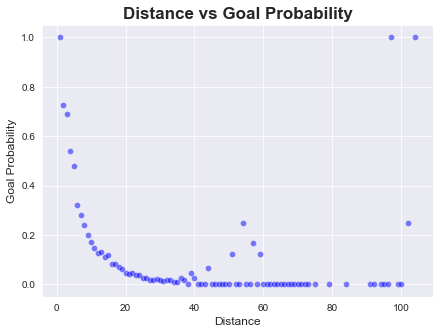

In [17]:
plt_distance_goals(dataset)

With the distance increases, the probability of getting a goal decreases. 

**Probability of Goal vs. Angle** 

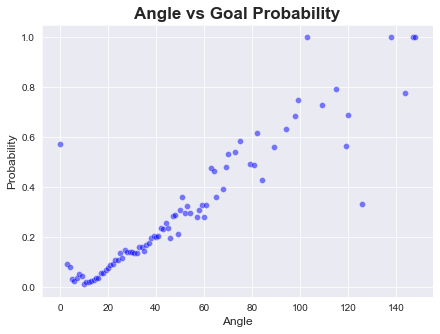

In [18]:
plt_angle_goals(dataset)

With angle increases, the probaility of getting a goal increases. 

In [19]:
event_all_leagues = []
for i in os.listdir("./data/events"):
    if (i == 'events_England.json') or (i == 'events_France.json') or (i == 'events_Spain.json') or (i == 'events_Germany.json') or (i == 'events_Italy.json'):
        event_all_leagues.append("./data/events/"+i)

In [20]:
all_leagues = []
for file in event_all_leagues:
    all_leagues.append(shot_matrix(file))
df_all_leagues = pd.concat(all_leagues)

In [21]:
df_all_leagues = get_tiddy_data(df_all_leagues)

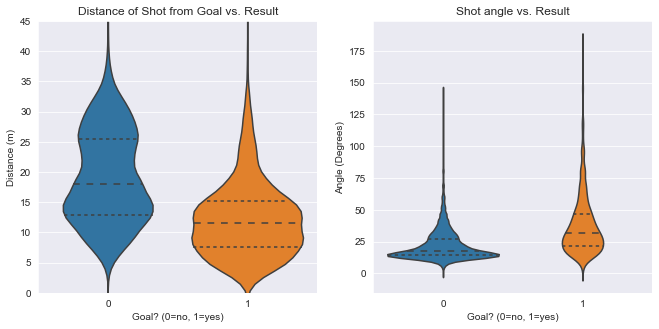

In [22]:
plot_violin_goal_dist_angle(df_all_leagues)

The violin plot above plays a similar role to a box and whiskers plot but also provides use with the kernel distribution estimate of the data (essentially a smoothing of the distribution). In splitting up the data by the result of the shot, we can see that on average, shots that result in goals are taken from much closer to goal than shots that do not result in goals. The mean of shots resulting in goals is about 12 meters compared to about 18 meters for those that don't bulge the net. Similarly, goals are typically scored from angles of 20 degrees to about 50 degrees. 

So while it is difficult to produce shooting chances close to goal, the violin plot suggests that those that are close and central tend to result in goals.

Let's see how headers impact the mean and the distributions.

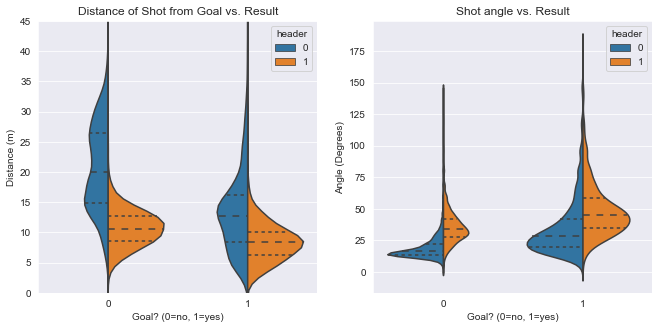

In [23]:
plot_violin_header_dist_angle(df_all_leagues)

Headers, as we might expect, are normally taken within the 18 yard box (16.5 m). Interestingly the means and distributions of the results do not differ by much, so that is something we should consider down the line.

**Probability of Goal vs. location** 

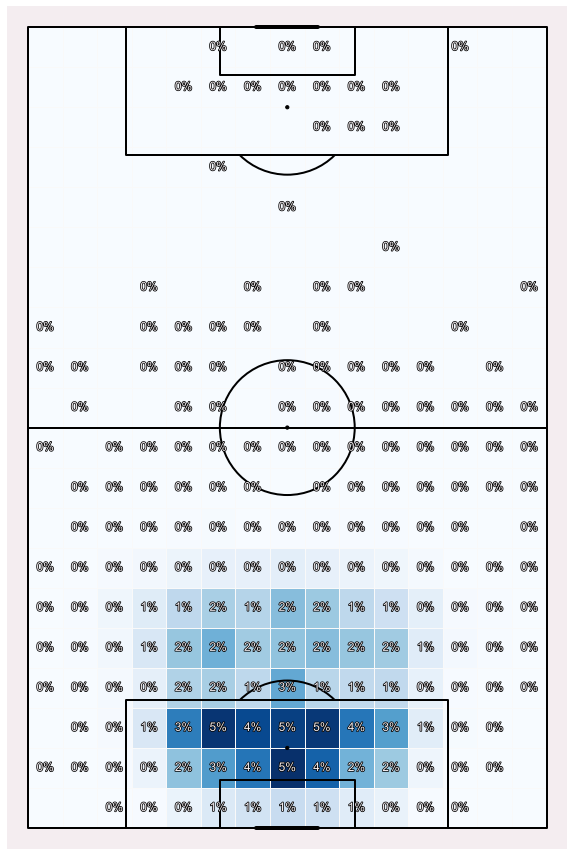

In [24]:
plt_location_goals(dataset)

The locations close to the goal and with relatively high angle have higher chance of getting a goal based on the visualization. 

With angle increases, the probability of getting a goal increases.

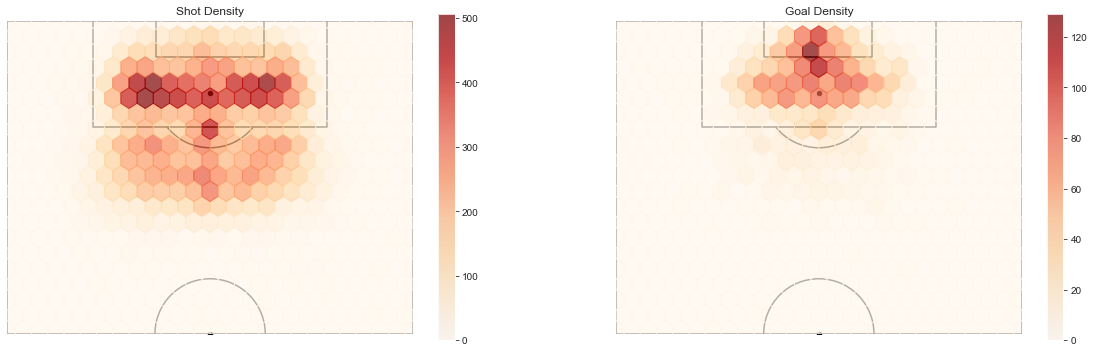

In [25]:
plot_shot_and_goal_density(df_all_leagues)

These density plots serve a similar function to the violin plots above but give us a much better visual understanding of which areas of the pitch normally produce shots and goals. This is because we can see how both distance and angle impact the distribution of shots on the same plot.

    1. As we learned with the violin plots:
        
    2. Shots are seldom taken from either side the box due to the poor angle

    3. A majority of the shots are taken around the penalty spot (11m)

    4. Goals are normally scored within 11 meters and within a very narrow passage

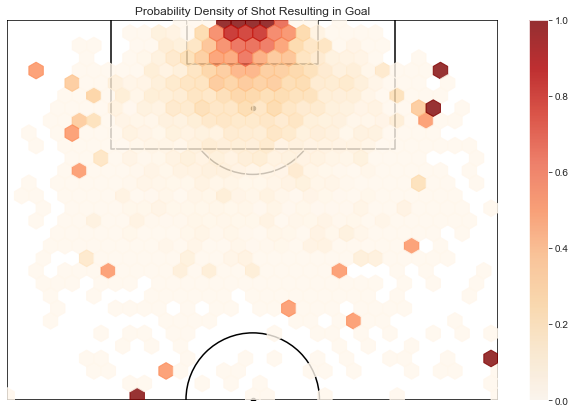

In [26]:
plot_shot_vs_goal(df_all_leagues)

As expected, the closer you shoot from the goal, the more likely the shot is to result in a goal. Notice that there are certain outliers in which the probability density in those bin are very high. This is because of the few shots taken from those areas, they resulted in goals. If we had say 10 seasons of data, we would see a much more homogenous probability density.

Now what about headers?

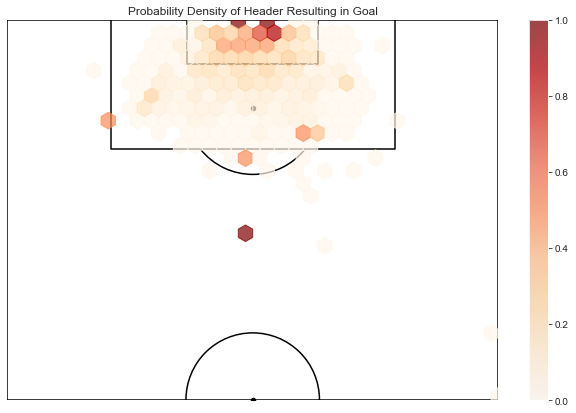

In [27]:
plot_header_vs_goal(df_all_leagues)

While headers exhibit a similar trend to regular shots, they have lower probability values overall. This seems to suggest that while headers happen closer to goal on average, they also represent a much more difficult chance to put away. As we will see down the line, this is an important discovery and one that impacts our interpretation of chance evaluation.

**Correlation matrix with other features** 

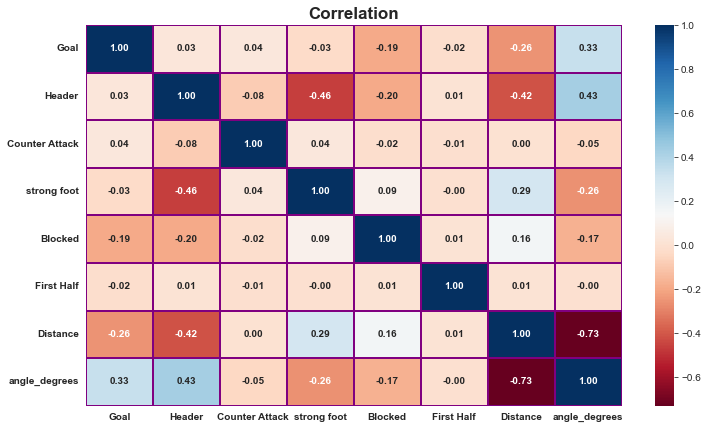

In [28]:
correlation_heatmap(dataset)

It seems the probability of getting a goal is strongly positively correlated to the Angle of shots, and it's strongly negatively correlated to the Distance of shots, which confirms our observations above. It's also negatively correlated to Blocked which makes sense because if a shot was blocked it's likely it will not get a goal. It has little correlation with other features. 

**Distribution of Distance and Angle** 

Knowing distance and angle are two most important factors affecting chance of getting goals, we want to analyze the distribution of these two features. 

In [29]:
# Distance 
print("Median: " + str(dataset["Distance"].quantile(0.5))) 
print("95% Percentile: " + str(dataset["Distance"].quantile(0.95))) 

Median: 16.812569702457743
95% Percentile: 31.86361561405108


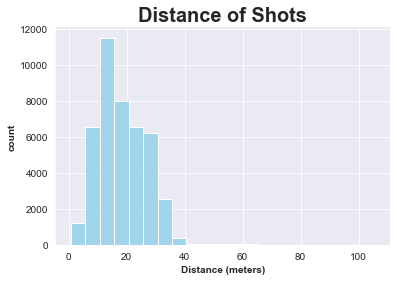

In [30]:
histp = sns.histplot(data = dataset, x = "Distance", binwidth = 5, color = "skyblue")

plt.title("Distance of Shots", weight = "bold", fontsize = 20)
plt.xlabel("Distance (meters)", weight = "semibold")
plt.ylabel("count", weight = "semibold")

sns.despine(right = True, top = True)

Over 95% shots occurred within 32 meters from the goal. Median distance is 16.8 meters. 

In [31]:
# Angle
print("Median: " + str(dataset["angle_degrees"].quantile(0.5))) 
print("95% Percentile: " + str(dataset["angle_degrees"].quantile(0.95))) 

Median: 19.275088487195234
95% Percentile: 51.81387903216682


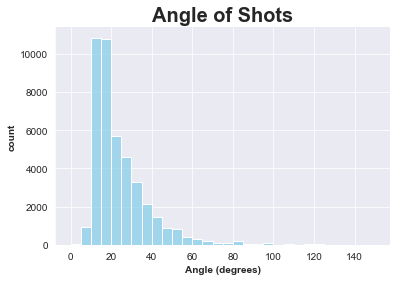

In [32]:
histp = sns.histplot(data = dataset, x = "angle_degrees", binwidth = 5, color = "skyblue")

plt.title("Angle of Shots", weight = "bold", fontsize = 20)
plt.xlabel("Angle (degrees)", weight = "semibold")
plt.ylabel("count", weight = "semibold")

sns.despine(right = True, top = True)

Over 95% shots had angle between 5 to 52 degrees. Median angle is 20 degrees. 

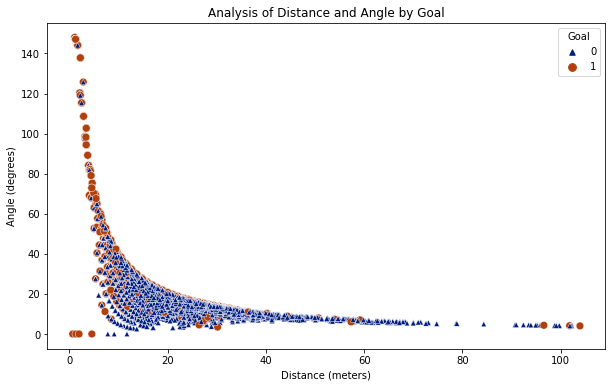

In [2]:
path = 'data/events/*.json'
path2 = 'data/players.json'
shots_model = dataLoader(path, path2)
analysisAD(shots_model)

This analysis can help user realized the relation among distance, angle and goal. We can observe when a player is close to the goal, he tends to shoot with a varity of angles. But as the distance get larger, he tend to shoot with relative low degrees.

## Teams and Players 

Other than those features of shots we analyzed above, it's also important to understant the performce of teams and players during matches. 

**Top 10 players** 

Analyze top 10 players based on the number of goals they attemped and the accuracy (the percentage of successful goals) of their attempts. Here, top 10 players are players with highest number of goals, not highest number of attempts. 

In [33]:
# Retrieve top 10 players from the shots dataset 
top50 = dataset.groupby("wyId").sum().sort_values("Goal", ascending = False)[0:50]
top50_accuracy = dataset.groupby("wyId").mean()["Goal"]

top50_attempts = dataset.groupby("wyId").count()["Goal"]
top50 = players.merge(top50, on = "wyId", how = "right")

top50["Accuracy"] = top50.apply(lambda x: top50_accuracy[x["wyId"]], axis = 1)
top50["Attempts"] = top50.apply(lambda x: top50_attempts[x["wyId"]], axis = 1)
top50 = top50.replace(to_replace = r"L. Su..*", value = "L. Suarez", regex = True)

top50[["shortName", "Attempts", "Goal", "Accuracy"]].head()

,shortName,Attempts,Goal,Accuracy
0,Mohamed Salah,141,32,0.226950
1,H. Kane,183,30,0.163934
2,Cristiano Ronaldo,196,28,0.142857
3,L. Messi,154,27,0.175325
4,E. Cavani,107,27,0.252336


Visualize the number of shots, goals and accuracy of top 10 players. The x axis represents number of goals, the y axis represents the accuracy, the size of the dot represents number of shots. 

127


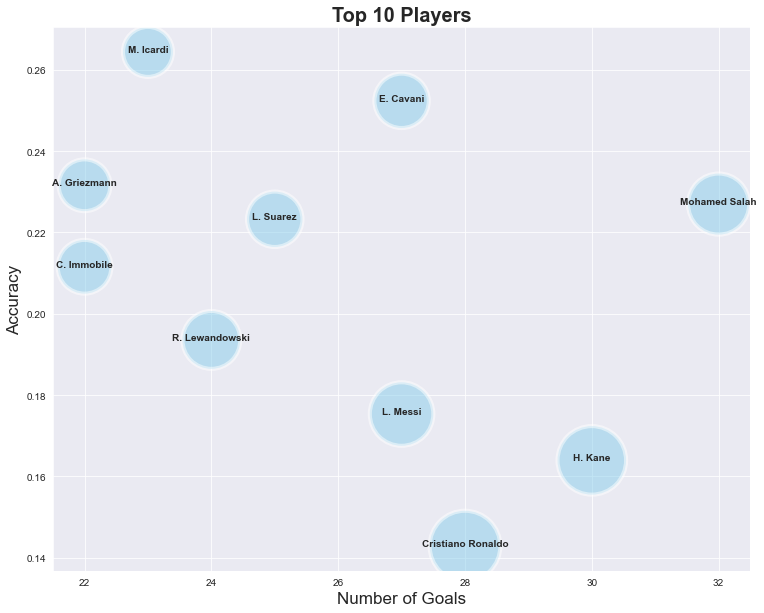

In [34]:
top10_players(top50)
print(127)

**Top 10 Teams** 

Analyze top 10 teams based on the number of goals they attemped and the accuracy (the percentage of successful goals) of their attempts. Here, top 10 teams are players with highest number of goals, not highest number of attempts.

In [35]:
# Retrieve top 10 teams from the shots dataset 
top50 = dataset.groupby("teamId").sum().sort_values("Goal", ascending = False)[0:50]
top50_accuracy = dataset.groupby("teamId").mean()["Goal"]

top50_attempts = dataset.groupby("teamId").count()["Goal"]
top50 = teams.merge(top50, on = "teamId", how = "right")

top50["Accuracy"] = top50.apply(lambda x: top50_accuracy[x["teamId"]], axis = 1)
top50["Attempts"] = top50.apply(lambda x: top50_attempts[x["teamId"]], axis = 1)
top50 = top50.replace(to_replace = r".*ayern.*", value = "Bayern Munchen", regex = True)

top50[["name", "Attempts", "Goal", "Accuracy"]].head()

,name,Attempts,Goal,Accuracy
0,Manchester City,603,94,0.155887
1,PSG,558,90,0.161290
2,Barcelona,502,87,0.173307
3,Bayern Munchen,535,83,0.155140
4,Real Madrid,631,81,0.128368


Visualize the number of attempts, goals and accuracy for top 10 teams. The x axis represents number of goals, the y axis represents the accuracy, the size of the dot represents number of attempts.

127


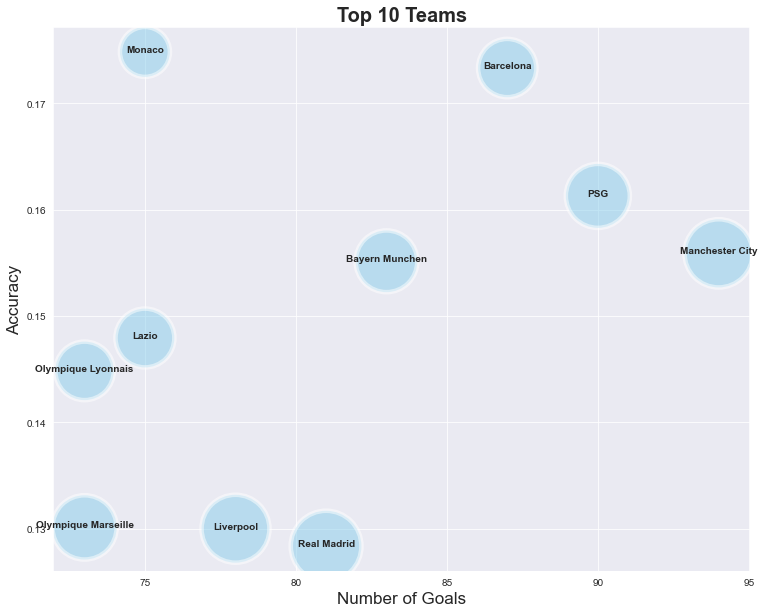

In [36]:
top10_teams(top50)
print(127)

# Model Prediction

## Training data with 9 sklearn model and visualize their classifying result to understand the relationship among distance, angle and goals, the nine models are as following

#### KNN model
we take k as 5 and predict the goal based on the nearest 5 points. If mostly points is one, then the model will guess one, otherwise it will guess zero.

#### Linear SVM
It mainly use support vectors to calculate margin and maximize it. The margin is calculate by the projection vector that obtained from two vectors. And then maximize margin under the condition that there is no point in the middle line.

#### RBF SVM
It's like Linear SVM but Project all data to higher dimensions so it can be easier to find linear hyperplanes for classifying.

#### Decision Tree
Decision Tree is learned to offer a series of questions through the features of training data, and then predict the category based on the questions. 

#### Random forest 
Random forest is derived from the decision tree but enhance its ability. It adopt several decision trees and train it with randomly picked-data. Then, take the majority decision from all decision trees as the prediction.

#### AdaBoost 
Just like random forest, AdaBoost is derived from and adopt several decision trees as classifiers to enhance its ability in classification. But adaboost trains them with several initialized weights distribution of the training data.By increasing the weight of the wrong data from the old classifier, the weighted training samples are used to train the new classifier. Therefore, the new classifier will learn more characteristics of the misclassified data.

#### Nueral Network
Use neural network with default 100 hidden layers to train a model as a non-linear classifier.

#### Gaussian Naive Bayes
This model computes the posterior probability for different distances and angles and then use this to predict the probability of goals.  

#### QDA classifier
It adopts the algorithm of linear discriminant analysis algorithm but additionally calculates the covariance of two variables (here is angle and distance) to get the relationship between the variables.


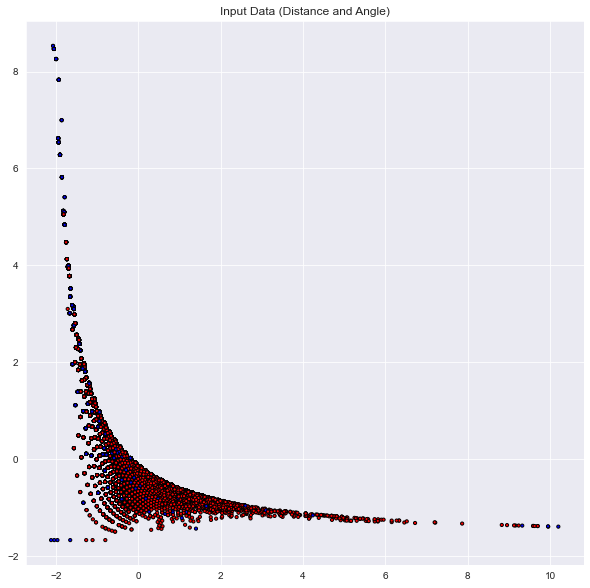

Nearest Neighbors 0.8848130003584658


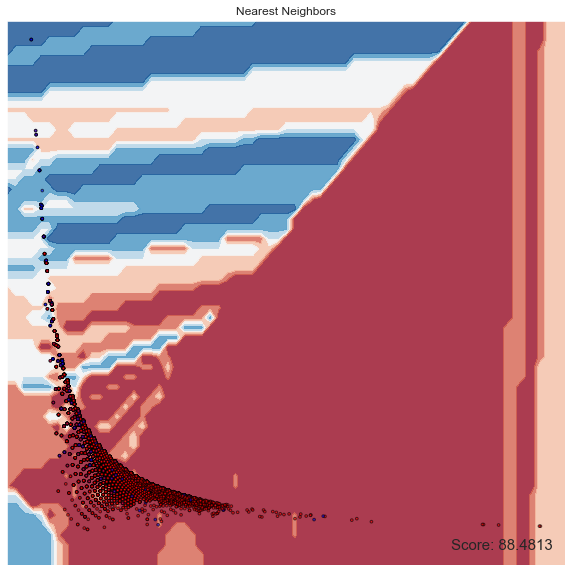

Linear SVM 0.8971203250089617


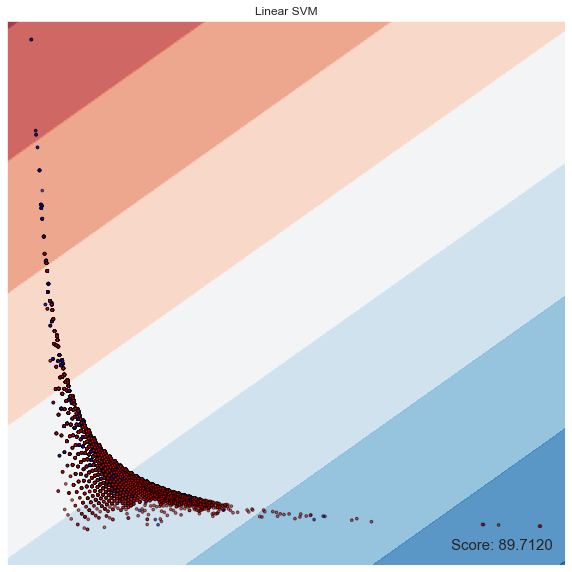

RBF SVM 0.8998685625522762


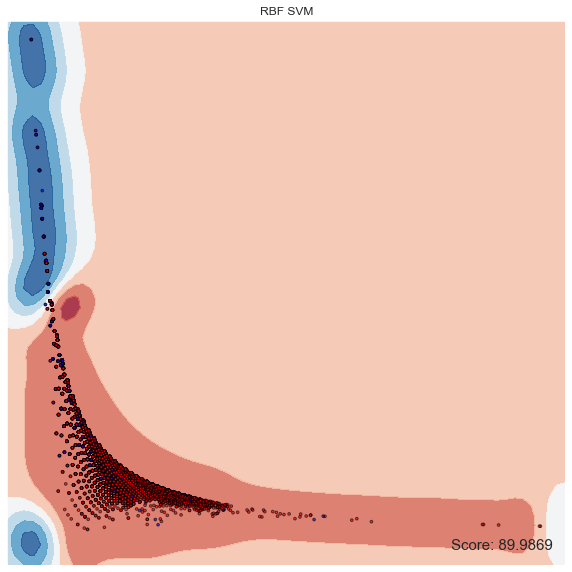

Decision Tree 0.8998685625522762


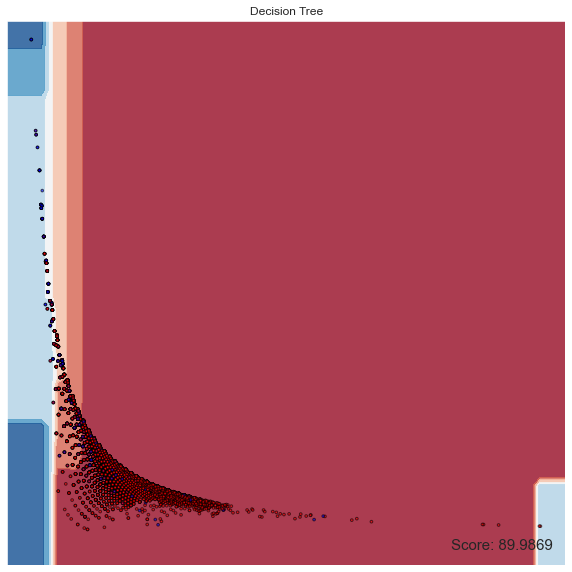

Random Forest 0.8998685625522762


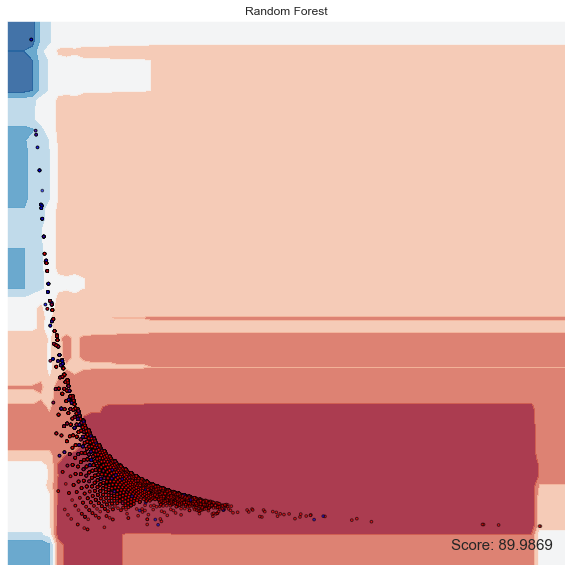

Neural Net 0.8997490739634365


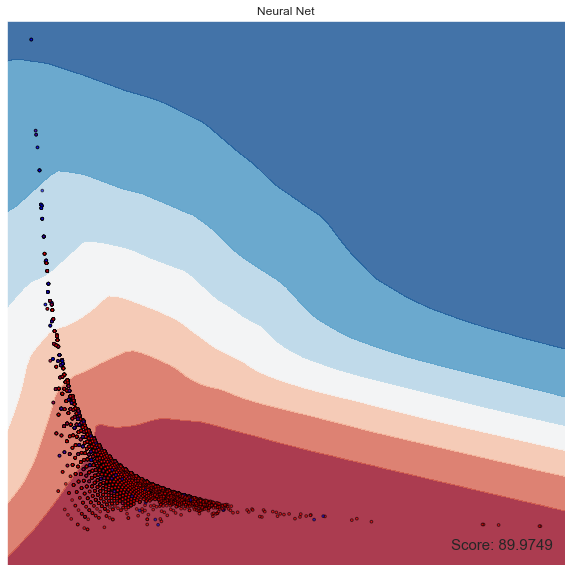

AdaBoost 0.899988051141116


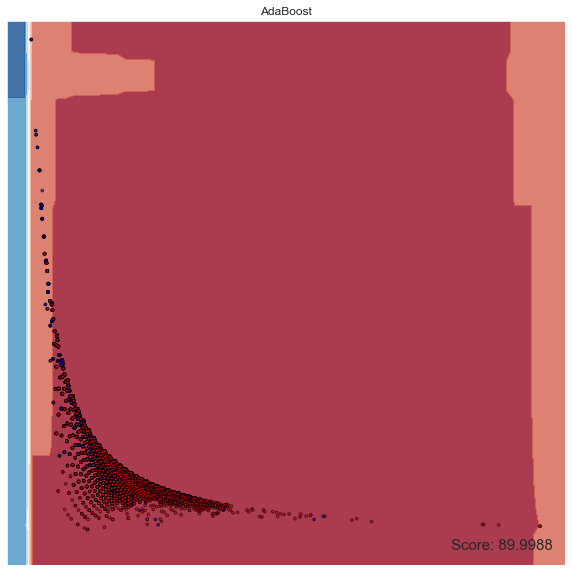

Naive Bayes 0.8752539132512845


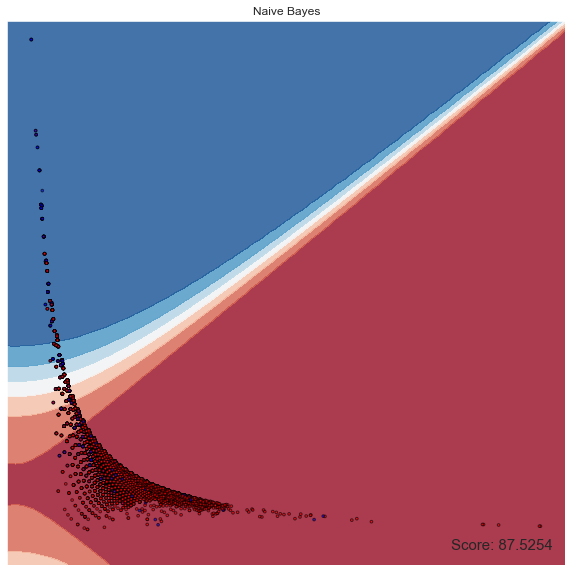

QuadraticDiscriminantAnalysis 0.8868443063687418


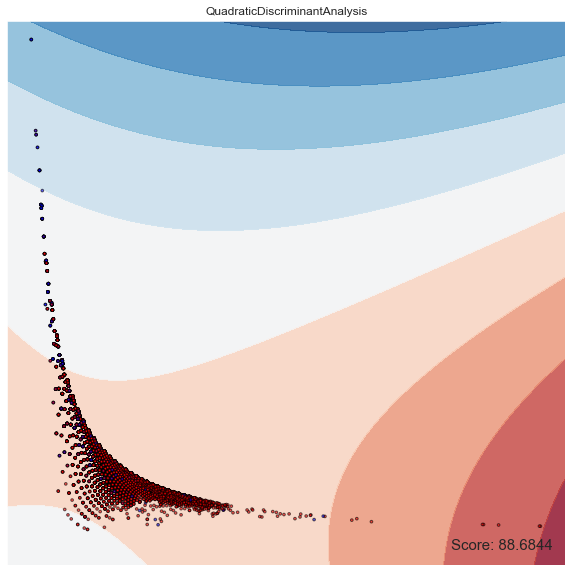

In [37]:
#path = 'data/events/*.json'
#path2 = 'data/players.json'
#shots_model = dataLoader(path, path2)
X, y, X_train, X_test, y_train_int, y_train, y_test_int, y_test = split_dataset(shots_model)
model_prediction_with_9models(X, y, X_train, X_test, y_train_int, y_train, y_test_int, y_test)

From Gaussian Naive Bayes, KNN, and QDA classifier for analysis, we can observe that in general the larger the distance is, the worse the shooting goal gets. And the figures also show that the effect of different angles plays a minor role when the player gets closer.

From another three tree-like models, decision tree, random forest, and AdaBoost, we can easily observe that models still tend to predict positively in several angles, not just small ones. So the skewness didn’t change anything to the correlation.

Besides, Multi-layers perceptron model and SVM models. All can solve non-linear problems and reach a really high scores but take time to train. 

##### Overall, our models prove that our assumption that distance and angles play a main role is correct since all of our models reach high scores.
##### And second, the skewness of the angle didn’t affect the positive correlation to the goal while not for the distance. 
##### Lastly, we can also conclude that the distance is more important than the angle do.


# Modeling Expected Goals

Our goal is to create a model to accurately describe our existing data as well as possible, and to eventually predict future events. Before applying logistic regression to our entire dataset, we must split our data into training and test sets. The training set serves at the data we build our model on, and the testing set is the data we use to evaluate how well our model performs.

## Logistic Regression

In [38]:
df_logistic = pd.concat(all_leagues)
#lets drop nan values and make sure our binary data is numeric for later
df_logistic = df_logistic.dropna()
#df = df.drop(columns = ['x','y','Center_dis'])
df_logistic['header'] = pd.to_numeric(df_logistic['header'])
df_logistic['Goal'] = pd.to_numeric(df_logistic['Goal'])

In [39]:
#we are going to split the data into a test and train set(20% of it will go towards testing)
#for now we are going to model just the distance predictor
train_2 = df_logistic[['Goal','Distance','Angle Radians']].copy()
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(train_2.drop('Goal',axis=1), 
                                                    train_2['Goal'], test_size=0.20, 
                                                    random_state=10)

In [40]:
# Logistic Regression Model between goal and distance, angle
coef, intercept = logistic_dist_angle(x_train_2, y_train_2)

In [41]:
print(pd.DataFrame(coef[0], 
                   x_train_2.columns, 
                   columns=['coef']).sort_values(by='coef', ascending=False))

                   coef
Angle Radians  1.415983
Distance      -0.088014


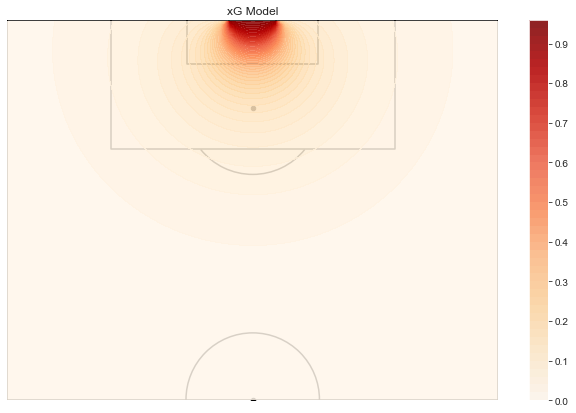

In [42]:
plot_logistic_model(coef, intercept)

This represents the simplest expected goals model. [Logistic Regression]

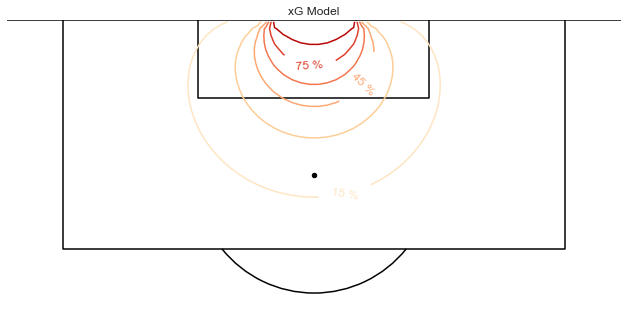

In [43]:
plot_logistic_contour(coef, intercept)

This is where we need to invoke some footballing knowledge. There is a 15% chance to score from 5 meters out and effectively zero angle with the goal! And if you are near the gate, you are more likely to get a score.